In [124]:
import pandas as pd
pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 100)

import seaborn as sns
sns.set_theme()

import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from scipy.signal import find_peaks

from sklearn import linear_model
from sklearn.cluster import KMeans

from math import floor

In [118]:
sensorlocations = ["Jharoda_Kalan","DTC_bus_terminal","Nangli_Dairy","ShaheenBagh","Sanjay_Colony_2","Tekhand2"]
cpcbLocations = ["najafgarh","okhla"]
allLocations = sensorlocations + cpcbLocations
sensorParameters = ["pm1_0","pm2_5","pm10","temp","humid"]
cpcbColumns = ['pm2_5', 'pm10']

ROLL_MEAN_LENGTH = '1H'
ROLL_BOUND_LENGTH = '1H'

def getRawData():
    allData = "https://raw.githubusercontent.com/sudhirattri/aq-data-scraper/main/eziodata/combined/db.csv"
    sensorData = pd.read_csv(allData,sep=',')
    cpcbLinks = [
    "https://raw.githubusercontent.com/sudhirattri/aq-data-scraper/main/eziodata/combined/naja_pollutants.csv",
    "https://raw.githubusercontent.com/sudhirattri/aq-data-scraper/main/eziodata/combined/naja_meter.csv",
    "https://raw.githubusercontent.com/sudhirattri/aq-data-scraper/main/eziodata/combined/okla_pollutants.csv",
    "https://raw.githubusercontent.com/sudhirattri/aq-data-scraper/main/eziodata/combined/okla_meter.csv"
    ]

    okla_pollutants = pd.read_csv(cpcbLinks[2],sep=',')
    okla_meter = pd.read_csv(cpcbLinks[3],sep=',')
    naja_pollutants = pd.read_csv(cpcbLinks[0],sep=',')
    naja_meter = pd.read_csv(cpcbLinks[1],sep=',')
    
    return sensorData,okla_pollutants,okla_meter,naja_pollutants,naja_meter

def combineCPCB(okla_pollutants,okla_meter,naja_pollutants,naja_meter):
    okla_cpcb = pd.merge(okla_pollutants, okla_meter, on='To Date', how='outer')
    naja_cpcb = pd.merge(naja_pollutants, naja_meter, on='To Date', how='outer')
    
    naja_cpcb = naja_cpcb.rename(columns={'To Date': 'timestamp', 'PM2.5': 'pm2_5','PM10': 'pm10'})
    okla_cpcb = okla_cpcb.rename(columns={'To Date': 'timestamp', 'PM2.5': 'pm2_5','PM10': 'pm10'})
    
    for i in cpcbColumns:
        naja_cpcb[i] = pd.to_numeric(naja_cpcb[i], errors='coerce')
        okla_cpcb[i] = pd.to_numeric(okla_cpcb[i], errors='coerce')
    cpcbData = {"najafgarh":naja_cpcb,"okhla":okla_cpcb}
    return cpcbData
    
def partDataByLoc(sensorData,cpcbData):
    allData = {}
    for loc in sensorlocations:
        allData[loc] = sensorData[sensorData["location"]==loc].copy()
    allData["najafgarh"] = cpcbData["najafgarh"]
    allData["okhla"] = cpcbData["okhla"]
    return allData

def convertTimeStamp(allData):
    format="%m/%d/%Y"
    for location in sensorlocations:
        allData[location]['timestamp'] = pd.to_datetime(allData[location]['timestamp'],unit='ms')
        allData[location] = allData[location].sort_values(by='timestamp',ascending=True)
        allData[location] = allData[location].set_index('timestamp')
        allData[location]["timestamp"] = allData[location].index
    for location in cpcbLocations:
        allData[location]['timestamp'] = pd.to_datetime(allData[location]['timestamp'],dayfirst=True)
        allData[location] = allData[location].sort_values(by='timestamp',ascending=True)
        allData[location] = allData[location].set_index('timestamp')
        allData[location]["timestamp"] = allData[location].index
    return allData

def getIntForTimeDate(row):
    timeFromStart = row["timestamp"].hour + (row["timestamp"].minute/60.0)
    return (timeFromStart) / 24.0
def getFractionalDayForTimeDate(row):
    timeFromStart = row["timestamp"].hour + (row["timestamp"].minute/60.0)
    fractionDay = (timeFromStart) / 24.0
    if(row["timestamp"].month==11):
        return row["timestamp"].day + fractionDay
    else:
        return 31.0 + row["timestamp"].day + fractionDay

def appendIntegerTime(allData):
    for locs in allLocations:
        allData[locs].loc[:,"integerTime"] = allData[locs].apply(lambda row: getIntForTimeDate(row), axis=1)
        allData[locs].loc[:,"fractionalDay"] = allData[locs].apply(lambda row: getFractionalDayForTimeDate(row), axis=1)
    return allData

def addRollingMeans(allData):
    for locs in sensorlocations:
        for i in sensorParameters:
            allData[locs]["roll_mean_" + i] = allData[locs][i].rolling(ROLL_MEAN_LENGTH,min_periods=1).mean().shift(-ROLL_MEAN_POINTS1//2)
            allData[locs]["roll_min_" + i] = allData[locs][i].rolling(ROLL_BOUND_LENGTH).min().shift(-ROLL_MEAN_POINTS1//2)
            allData[locs]["roll_max_" + i] = allData[locs][i].rolling(ROLL_BOUND_LENGTH).max().shift(-ROLL_MEAN_POINTS1//2)
    for locs in cpcbLocations:
        for i in ["pm2_5","pm10"]:
            allData[locs]["roll_mean_" + i] = allData[locs][i].rolling(ROLL_MEAN_LENGTH).mean().shift(-ROLL_MEAN_POINTS2//2)
            allData[locs]["roll_min_" + i] = allData[locs][i].rolling(ROLL_BOUND_LENGTH).min().shift(-ROLL_MEAN_POINTS2//2)
            allData[locs]["roll_max_" + i] = allData[locs][i].rolling(ROLL_BOUND_LENGTH).max().shift(-ROLL_MEAN_POINTS2//2)
    return allData

def plotOneParamOnly(listSeries,listlabels,df1,ax,density=4,title="data"):
    for i in range(len(listSeries)):
        g = sns.lineplot(x="fractionalDay", y="roll_mean_"+listSeries[i], data=df1,ax=ax, label=listlabels[i],ci=None,
                         )
        ax.fill_between(df1["fractionalDay"],df1["roll_min_"+listSeries[i]],df1["roll_max_"+listSeries[i]],alpha=0.1)
#         g = sns.lineplot(x="fractionalDay", y=""+listSeries[i], data=df1,ax=ax, label=listlabels[i],ci=None)

    d1 = df1["timestamp"][0]
    d2 = df1["timestamp"][-1]
    diff = d2.day-d1.day+1
    print(d1,d2,diff)
    xticks = []
    xticks_labels = []

    for i in range(d1.day,d2.day+1):
        xticks.append(i)
        xticks_labels.append(str(int(i))+ " Nov")
        ax.axvline(i,linestyle="--",label="day line",c='r')
        for j in range(1,density):
            hour = j*(floor(24/density))
            xticks.append(i+(hour/24))
            if(hour<12):
                xticks_labels.append(str(int(hour)) + " AM")
            elif(hour==12):
                xticks_labels.append(str(int(hour)) + " PM")
            else:
                xticks_labels.append(str(int(hour-12)) + " PM")
                
    g.set_xticks(xticks)
    g.set_xticklabels(xticks_labels,fontsize=18)

    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(title,fontsize=24)

def sliceByDateRange(start,end,df):
    startTime = pd.to_datetime(start)
    endTime =  pd.to_datetime(end)
    res = df[(df["timestamp"]>=startTime) & (df["timestamp"]<endTime)]
    return res

In [ ]:
sensorlocations = ["Jharoda_Kalan","DTC_bus_terminal","Nangli_Dairy","ShaheenBagh","Sanjay_Colony_2","Tekhand2"]
cpcbLocations = ["najafgarh","okhla"]
allLocations = sensorlocations + cpcbLocations
sensorParameters = ["pm1_0","pm2_5","pm10","temp","humid"]
cpcbColumns = ['pm2_5', 'pm10']

In [3]:
sensorData,okla_pollutants,okla_meter,naja_pollutants,naja_meter = getRawData()

In [120]:
cpcbData = combineCPCB(okla_pollutants,okla_meter,naja_pollutants,naja_meter)
allData = partDataByLoc(sensorData,cpcbData)
allData = convertTimeStamp(allData)
allData = appendIntegerTime(allData)
for i in allLocations:
    allData[i] = df.resample('1T').mean()
    allData[i]['timestamp'] = allData[i].index 
allData = addRollingMeans(allData)

2021-11-22 00:00:00 2021-11-24 23:59:00 3
2021-11-25 00:00:00 2021-11-27 23:59:00 3


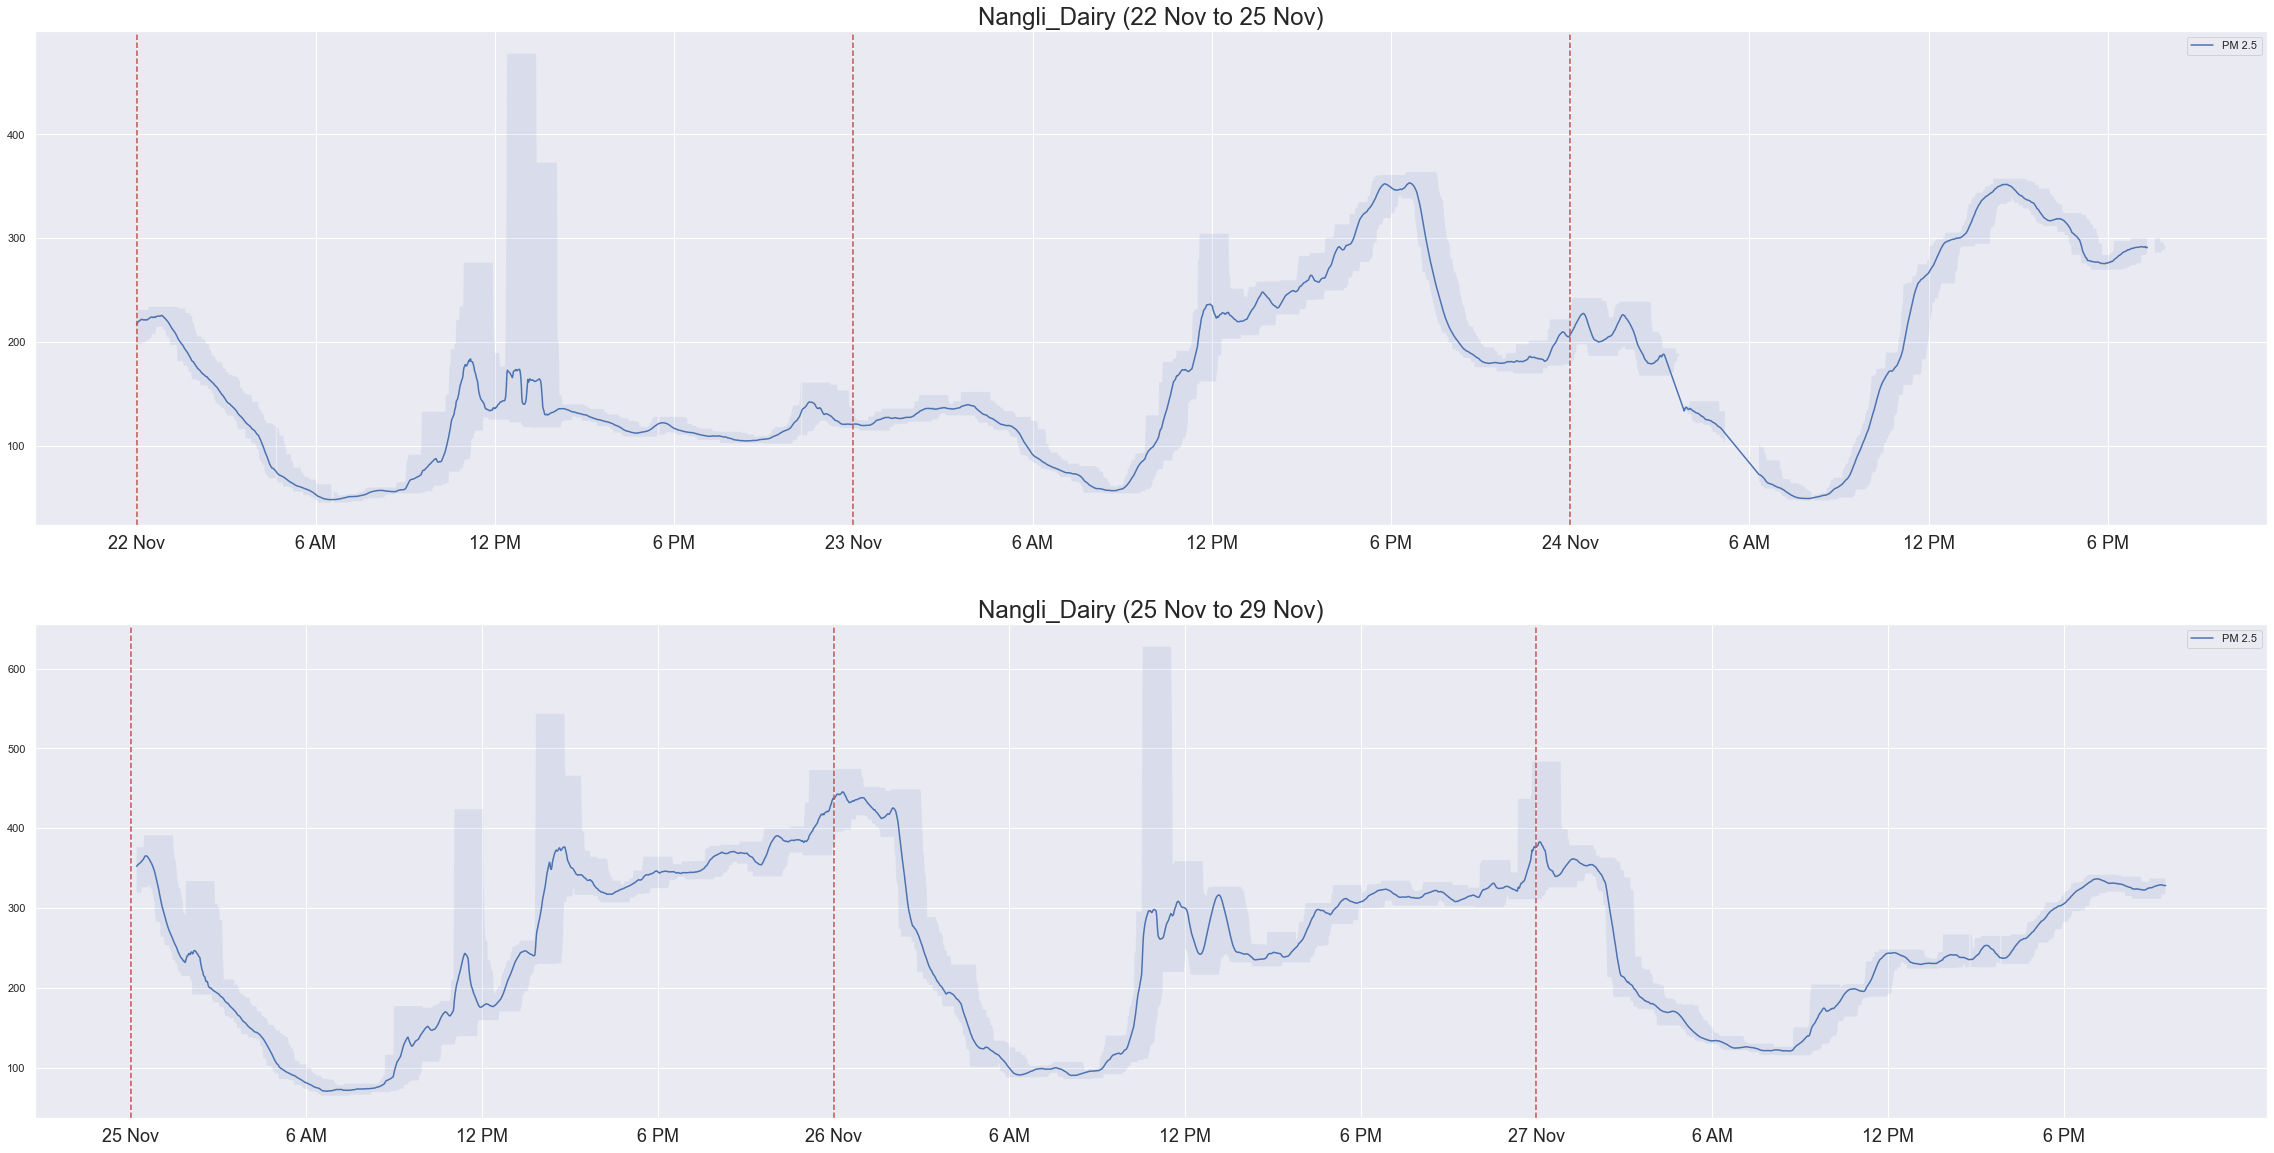

In [122]:
df1 = sliceByDateRange('2021-11-22','2021-11-25',df)
df2 = sliceByDateRange('2021-11-25','2021-11-29',df)
fig, ax = plt.subplots(2,figsize=(40, 20))
plotOneParamOnly(["pm2_5"],["PM 2.5"],df1,ax[0],density=4,title=str("Nangli_Dairy")+" (22 Nov to 25 Nov)")
plotOneParamOnly(["pm2_5"],["PM 2.5"],df2,ax[1],density=4,title=str("Nangli_Dairy")+" (25 Nov to 29 Nov)")